In [3]:
# tone_train_test_embedding: imports

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from cebra import CEBRA
from core import (
    DEFAULT_DATA_ROOT,
    train_test_split_neuropixel_only,
    split_by_period_3way,
    load_sessions_raw,
    compute_neuron_intersection,
    apply_neuron_cut,
    zscore_per_session,
)


In [4]:
# tone_train_test_embedding: prepare train/test tone tensors

root = DEFAULT_DATA_ROOT
print(f"Using data root: {root}")

# 1) Get all Neuropixels sessions under "firing rates"
train_paths, test_paths = train_test_split_neuropixel_only(
    root,
    test_size=0.2,
    random_seed=0,
)
print("TRAIN total sessions:", len(train_paths))
print("TEST  total sessions:", len(test_paths))

# 2) Split into free / tone / post
train_free, train_tone, train_post = split_by_period_3way(train_paths)
test_free, test_tone, test_post = split_by_period_3way(test_paths)

print("TRAIN tone sessions:", len(train_tone))
print("TEST  tone sessions:", len(test_tone))

# 3) Load tone sessions (raw)
train_sessions = load_sessions_raw(train_tone)
test_sessions = load_sessions_raw(test_tone)

# 4) Compute shared neuron dimension and align
n_shared = compute_neuron_intersection(train_sessions)
print("Shared neurons (tone):", n_shared)

train_sessions = apply_neuron_cut(train_sessions, n_shared)
test_sessions = apply_neuron_cut(test_sessions, n_shared)

# 5) Z-score per session, stack to tensors
train_sessions = zscore_per_session(train_sessions)
test_sessions = zscore_per_session(test_sessions)

X_train_tone = np.vstack(train_sessions)
X_test_tone = np.vstack(test_sessions)

print("Final TRAIN tensor:", X_train_tone.shape)
print("Final TEST  tensor:", X_test_tone.shape)


Using data root: /Users/Columbia/Downloads/transcriptomics_ym/CEBRA_source_test/preprocessed time series
TRAIN total sessions: 72
TEST  total sessions: 18
TRAIN tone sessions: 28
TEST  tone sessions: 2
Shared neurons (tone): 2100
Final TRAIN tensor: (3155, 2100)
Final TEST  tensor: (229, 2100)


In [5]:
# tone_train_test_embedding: train CEBRA-Time

cebra_model = CEBRA(
    model_architecture="offset10-model",
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.0,
    output_dimension=3,
    max_iterations=5000,
    distance="cosine",
    verbose=True,
    device="cuda_if_available",
)

cebra_model.fit(X_train_tone)
emb_train_tone = cebra_model.transform(X_train_tone)
emb_test_tone = cebra_model.transform(X_test_tone)

print("Train embedding:", emb_train_tone.shape)
print("Test  embedding:", emb_test_tone.shape)


pos: -0.9985 neg:  6.4003 total:  5.4018 temperature:  1.0000: 100%|██████████| 5000/5000 [02:54<00:00, 28.67it/s]


Train embedding: (3155, 3)
Test  embedding: (229, 3)


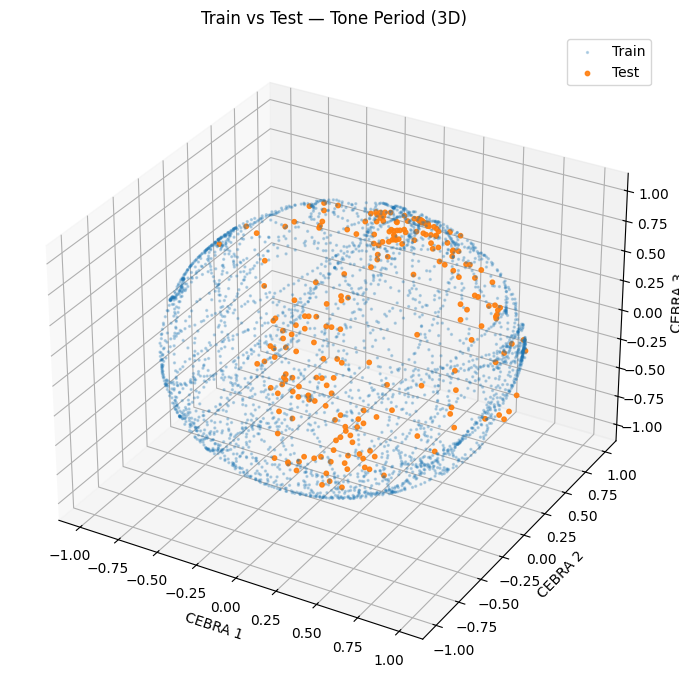

In [10]:
# tone_train_test_embedding: 3D visualization

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    emb_train_tone[:, 0],
    emb_train_tone[:, 1],
    emb_train_tone[:, 2],
    s=2,
    alpha=0.25,
    label="Train",
)

ax.scatter(
    emb_test_tone[:, 0],
    emb_test_tone[:, 1],
    emb_test_tone[:, 2],
    s=10,
    alpha=0.9,
    label="Test",
)

ax.set_xlabel("CEBRA 1")
ax.set_ylabel("CEBRA 2")
ax.set_zlabel("CEBRA 3")
ax.set_title("Train vs Test — Tone Period (3D)")
ax.legend()
plt.tight_layout()
plt.show()
